## Imports

In [68]:
import time

import numpy as np
import cv2 as cv
import os
import glob
import matplotlib.pyplot as plt
from cv2 import cvtColor
from numpy.random import uniform
import pdb
from tqdm import tqdm



## Show functions

In [69]:
def show_image_cv(title,image,fx=1,fy=1,output = True):

    if not output:
        return

    image = cv.resize(image,(0,0),fx=fx,fy=fy)
    cv.imshow(title, image)
    cv.waitKey(0)
    cv.destroyAllWindows()

def show_image_matplot(title, image,fx=1,fy=1,output = True):
    if not output:
        return

    image_resized = cv.resize(image, (0, 0), fx=fx, fy=fy)

    image = cv.cvtColor(image_resized, cv.COLOR_BGR2RGB)

    plt.imshow(image)
    plt.title(title)
    plt.axis('off')  # Ascunde axele pentru a afișa doar imaginea
    plt.show()

## Directory and files functions

In [70]:
def get_image_paths(dir,index):
    image_paths = os.listdir(dir)
    image_paths = ["./" + dir + "/" + file for file in image_paths if file[0:2] == str(index) + "_" and file[-4:] == ".jpg"]
    return sorted(image_paths)


## HSV masking

In [71]:
# hsv mask

def get_outer_masked_image(img,output = False):
    lower_hsv_bound = np.array([20,0,0])
    upper_hsv_bound = np.array([255,255,255])
    hsv_image = cv.cvtColor(img, cv.COLOR_BGR2HSV)

    mask = cv.inRange(hsv_image, lower_hsv_bound, upper_hsv_bound)
    show_image_cv("mask",mask,output = output)

    new_image = cv.bitwise_and(img, img, mask=mask)
    show_image_cv("ceva",new_image,output = output)

    return new_image



## Get game contour function


In [72]:
def get_game_countour(image,output = False):

    masked_image = get_outer_masked_image(image)
    masked_image_grey = cv.cvtColor(masked_image, cv.COLOR_BGR2GRAY)

    show_image_cv("masked_image_grey",masked_image_grey,output = output)

    masked_image_grey = cv.medianBlur(masked_image_grey,3)
    show_image_cv('median_blur_image',masked_image_grey,output = output)

    contours, _ = cv.findContours(masked_image_grey,  cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    max_area = 0
    for i in range(len(contours)):
            if(len(contours[i]) >3):
                possible_top_left = None
                possible_bottom_right = None
                for point in contours[i].squeeze():
                    if possible_top_left is None or point[0] + point[1] < possible_top_left[0] + possible_top_left[1]:
                        possible_top_left = point

                    if possible_bottom_right is None or point[0] + point[1] > possible_bottom_right[0] + possible_bottom_right[1] :
                        possible_bottom_right = point

                diff = np.diff(contours[i].squeeze(), axis = 1)
                possible_top_right = contours[i].squeeze()[np.argmin(diff)]
                possible_bottom_left = contours[i].squeeze()[np.argmax(diff)]
                if cv.contourArea(np.array([[possible_top_left],[possible_top_right],[possible_bottom_right],[possible_bottom_left]])) > max_area:
                    max_area = cv.contourArea(np.array([[possible_top_left],[possible_top_right],[possible_bottom_right],[possible_bottom_left]]))
                    top_left = possible_top_left
                    bottom_right = possible_bottom_right
                    top_right = possible_top_right
                    bottom_left = possible_bottom_left


    image_copy = cv.cvtColor(masked_image_grey.copy(),cv.COLOR_GRAY2BGR)
    cv.circle(image_copy,tuple(top_left),20,(0,0,255),-1)
    cv.circle(image_copy,tuple(top_right),20,(0,0,255),-1)
    cv.circle(image_copy,tuple(bottom_left),20,(0,0,255),-1)
    cv.circle(image_copy,tuple(bottom_right),20,(0,0,255),-1)
    show_image_cv("detected corners",image_copy,output = output)


    width = 810
    height = 810

    puzzle = np.array([top_left,top_right,bottom_left,bottom_right],dtype=np.float32)
    destination = np.array([[0,0],[width,0],[0,height],[width,height]],dtype=np.float32)
    M = cv.getPerspectiveTransform(puzzle,destination)
    result = cv.warpPerspective(image,M,(width,height))

    return result

## Game table extractor

In [73]:
def extract_game(image_paths,size = 1000):
    images = []
    size = size if size <= len(image_paths) else len(image_paths)
    for i in tqdm(range(size)):
        img = cv.imread(image_paths[i])
        result = get_game_countour(img)
        images.append(result)
    return np.array(images)

def strip_margins(img,cell_size = 150,output = False):

    img = img.copy()
    img_grey = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    BLACK = 0

    height,width,_ = img.shape

    # somewhere between 13% and 14% of the height and width of the image
    top_margin = 107
    bottom_margin = height - 102
    left_margin = 107
    right_margin = width - 105

    img_grey[:top_margin, :] = BLACK
    img_grey[bottom_margin:, :] = BLACK

    img_grey[:, :left_margin] = BLACK
    img_grey[:, right_margin:] = BLACK

    show_image_cv("ceva",img_grey,fx=1,fy=1,output = output)

    masked_image_grey = img_grey

    contours, _ = cv.findContours(masked_image_grey,  cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    max_area = 0
    for i in range(len(contours)):
            if(len(contours[i]) >3):
                possible_top_left = None
                possible_bottom_right = None
                for point in contours[i].squeeze():
                    if possible_top_left is None or point[0] + point[1] < possible_top_left[0] + possible_top_left[1]:
                        possible_top_left = point

                    if possible_bottom_right is None or point[0] + point[1] > possible_bottom_right[0] + possible_bottom_right[1] :
                        possible_bottom_right = point

                diff = np.diff(contours[i].squeeze(), axis = 1)
                possible_top_right = contours[i].squeeze()[np.argmin(diff)]
                possible_bottom_left = contours[i].squeeze()[np.argmax(diff)]
                if cv.contourArea(np.array([[possible_top_left],[possible_top_right],[possible_bottom_right],[possible_bottom_left]])) > max_area:
                    max_area = cv.contourArea(np.array([[possible_top_left],[possible_top_right],[possible_bottom_right],[possible_bottom_left]]))
                    top_left = possible_top_left
                    bottom_right = possible_bottom_right
                    top_right = possible_top_right
                    bottom_left = possible_bottom_left


    image_copy = cv.cvtColor(masked_image_grey.copy(),cv.COLOR_GRAY2BGR)
    cv.circle(image_copy,tuple(top_left),2,(0,0,255),-1)
    cv.circle(image_copy,tuple(top_right),2,(0,0,255),-1)
    cv.circle(image_copy,tuple(bottom_left),2,(0,0,255),-1)
    cv.circle(image_copy,tuple(bottom_right),2,(0,0,255),-1)
    show_image_cv("detected corners",image_copy,output = output,fx=1,fy=1)


    width = 14 * cell_size
    height = 14 * cell_size

    puzzle = np.array([top_left,top_right,bottom_left,bottom_right],dtype=np.float32)
    destination = np.array([[0,0],[width,0],[0,height],[width,height]],dtype=np.float32)
    M = cv.getPerspectiveTransform(puzzle,destination)
    result = cv.warpPerspective(img,M,(width,height))

    return result

def extract_relevant_game(images):
    new_images = []

    for image in tqdm(images):
        new_images.append(strip_margins(image))

    return np.array(new_images)


In [74]:
game_tables = extract_game(get_image_paths("antrenare",1))


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


In [75]:
relevant_game_tables = extract_relevant_game(game_tables)

100%|██████████| 50/50 [00:00<00:00, 108.82it/s]


## Cell delimiter function

In [76]:

def get_lines_coords(cell_size = 150):
    lines_horizontal = []
    for i in range(0,14*cell_size+1,cell_size):
        line = []
        line.append((0,i))
        line.append((14*60-1,i))
        lines_horizontal.append(line)

    lines_vertical = []
    for i in range(0,14*cell_size+1,cell_size):
        line = []
        line.append((i,0))
        line.append((i,14*cell_size-1))
        lines_vertical.append(line)

    return lines_vertical,lines_horizontal

def draw_lines(images):

    new_images = images.copy()

    lines_vertical,lines_horizontal = get_lines_coords()

    GREEN = (0,255,0)
    RED = (0,0,255)

    for image in tqdm(new_images):
        for line in lines_vertical:
            cv.line(image,line[0],line[1],GREEN,2)

        for line in lines_horizontal:
            cv.line(image,line[0],line[1],RED,2)

    return new_images


In [77]:
delimited_tables = draw_lines(relevant_game_tables)


100%|██████████| 50/50 [00:00<00:00, 1124.52it/s]


In [78]:
paths = ["./imagini_auxiliare/" + file for file in os.listdir("./imagini_auxiliare")]
test_tables = extract_game(paths)
game_tables = extract_relevant_game(test_tables)

lines = draw_lines(game_tables)

100%|██████████| 4/4 [00:00<00:00, 930.47it/s]


In [79]:

def get_pieces_numbers():
    return [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 24, 25, 27, 28, 30, 32, 35, 36, 40, 42, 45, 48, 49, 50, 54, 56, 60, 63, 64, 70, 72, 80, 81, 90]

## Template extractor from sample images

In [80]:
def store_template_numbers1(offset = 0):

    img = ["./imagini_auxiliare/03.jpg"]
    table = extract_game(img)
    game_table = extract_relevant_game(table)[0]

    lines_vertical,lines_horizontal = get_lines_coords()

    piece_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 24, 25, 27, 28, 30, 32, 35, 36, 40, 42, 45, 48, 49, 50, 54, 56, 60, 63, 64, 70, 72, 80, 81, 90]

    index = 0

    for i in range(5,11):
        for j in range(4,12):

            if index == len(piece_values):
                return

            y_min = lines_vertical[j][0][0] + offset
            y_max = lines_vertical[j + 1][1][0] - offset
            x_min = lines_horizontal[i][0][1] + offset
            x_max = lines_horizontal[i + 1][1][1] - offset

            patch = game_table[x_min:x_max,y_min:y_max:].copy()
            cv.imwrite("./templates/sample3/" + str(piece_values[index])+ ".jpg", patch)
            index += 1



def store_template_numbers2(offset = 5):

    img = ["./imagini_auxiliare/04.jpg"]
    table = extract_game(img)
    game_table = extract_relevant_game(table)[0]

    lines_vertical,lines_horizontal = get_lines_coords()

    piece_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 24, 25, 27, 28, 30, 32, 35, 36, 40, 42, 45, 48, 49, 50, 54, 56, 60, 63, 64, 70, 72, 80, 81, 90]

    index = 0

    for i in range(0,len(lines_horizontal)-1,2):
        for j in range(0,len(lines_vertical)-1,2):

            if index == len(piece_values):
                return

            y_min = lines_vertical[j][0][0] + offset
            y_max = lines_vertical[j + 1][1][0] - offset
            x_min = lines_horizontal[i][0][1] + offset
            x_max = lines_horizontal[i + 1][1][1] - offset

            patch = game_table[x_min:x_max,y_min:y_max:].copy()
            cv.imwrite("./templates/sample4/" + str(piece_values[index])+ ".jpg", patch)
            index += 1


def store_thresholded_templates(source_path = "./templates/sample4",destination_path = "./thresholded_templates/sample4"):
    paths = sorted(os.listdir(source_path))

    for path in paths:
        img = cv.imread(os.path.join(source_path,path))
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

        _, img = cv.threshold(img,80,255,cv.THRESH_BINARY_INV)
        cv.imwrite(os.path.join(destination_path,path), img)



In [84]:
store_template_numbers2(20)
store_thresholded_templates(source_path = "./templates/sample4",destination_path = "./thresholded_templates/sample4")

100%|██████████| 1/1 [00:00<00:00, 122.38it/s]


In [85]:
def classify_number(patch):

    maxi = -np.inf
    chosen_number = -1
    numbers = get_pieces_numbers()

    for number in numbers:
        template = cv.imread("./thresholded_templates/sample4/" + str(number) + ".jpg")
        template = cv.cvtColor(template, cv.COLOR_BGR2GRAY)
        corr = cv.matchTemplate(patch,template, cv.TM_CCOEFF_NORMED)
        corr=np.max(corr)

        if corr > maxi:
            maxi = corr
            chosen_number = number


    return chosen_number

def get_number_pos(thresholded_image,offset):
    lines_vertical,lines_horizontal = get_lines_coords()

    coords=[]
    patches = []

    for i in range(len(lines_horizontal)-1):
        for j in range(len(lines_vertical)-1):

            y_min = lines_vertical[j][0][0] + offset
            y_max = lines_vertical[j + 1][1][0] - offset
            x_min = lines_horizontal[i][0][1] + offset
            x_max = lines_horizontal[i + 1][1][1] - offset

            patch = thresholded_image[x_min:x_max,y_min:y_max].copy()
            patches.append(patch)

            mean = np.mean(patch)
            h,w = patch.shape

            if mean > (255 * 15) / (h * w) :
                predicted_number = classify_number(patch)
                coords.append((i,j,predicted_number))
            #     show_image_matplot("patch " + str(i)+ " " + str(j) + " "+ str(predicted_number), patch)
            # else:
            #     show_image_matplot("patch " + str(i)+ " " + str(j), patch)
    return coords,patches



In [86]:
img = relevant_game_tables[49]
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
_, img = cv.threshold(img,80,255,cv.THRESH_BINARY_INV)
show_image_cv("ceva",img)

coords,patches = get_number_pos(img,20)

for coord in coords:
    index = coord[0] * 14 + coord[1]
    show_image_cv(str(coord[2]),patches[index])

KeyboardInterrupt: 

[(0, 7, 13), (0, 9, 81), (1, 7, 15), (1, 9, 6), (2, 7, 16), (2, 8, 64), (2, 9, 9), (3, 7, 63), (3, 9, 6), (3, 11, 45), (4, 7, 19), (4, 9, 9), (4, 11, 35), (4, 12, 64), (5, 3, 9), (5, 4, 14), (5, 5, 11), (5, 6, 3), (5, 7, 9), (5, 8, 9), (5, 9, 8), (5, 10, 10), (5, 11, 14), (5, 12, 21), (6, 6, 1), (6, 7, 4), (6, 8, 9), (6, 9, 6), (6, 10, 8), (6, 11, 3), (6, 12, 1), (7, 5, 7), (7, 6, 11), (7, 7, 9), (7, 8, 7), (7, 9, 8), (7, 10, 72), (7, 12, 1), (8, 4, 6), (8, 5, 13), (8, 6, 3), (8, 7, 9), (8, 8, 13), (8, 10, 45), (8, 11, 64), (9, 3, 9), (9, 4, 21), (9, 5, 6), (9, 6, 5), (9, 7, 56), (9, 8, 17), (9, 9, 80), (10, 4, 8), (10, 7, 80), (10, 8, 3), (10, 9, 1), (11, 7, 72), (11, 8, 10), (12, 8, 10), (12, 9, 20), (13, 8, 20)]


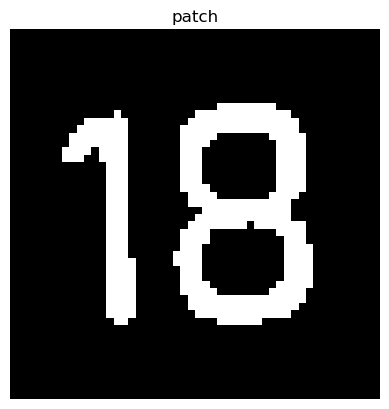

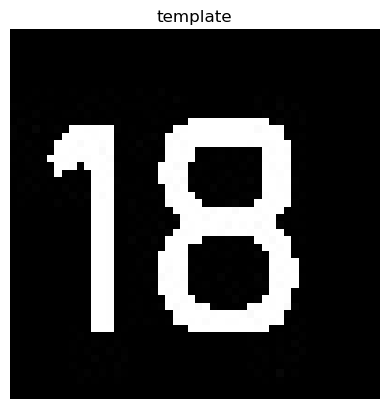

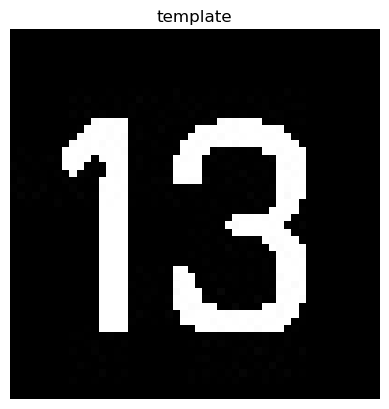

[[0.62531865]] [[0.42250505]]


In [41]:
print(coords)
sample = patches[7]
cv.imwrite("test.jpg", sample)
show_image_matplot("patch",sample)
eight = cv.cvtColor(cv.imread("./thresholded_templates/sample4/18.jpg"), cv.COLOR_BGR2GRAY)
show_image_matplot("template",eight)
ten = cv.cvtColor(cv.imread("./thresholded_templates/sample4/13.jpg"),cv.COLOR_BGR2GRAY)
show_image_matplot("template",ten)

corr1 = cv.matchTemplate(sample,ten,cv.TM_CCOEFF_NORMED)
corr2 = cv.matchTemplate(sample,eight,cv.TM_CCOEFF_NORMED)

print(corr1,corr2)